In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import community

%matplotlib inline

In [2]:
records = pd.read_csv('scraped_results_df.csv')
# 'game_loc' indicated where the game was played at. Since the winner is listed first in 
# the original data, the '@' indicates the game was played at the loser's home.  Therefore, 
# we can create a new column called 'Winner_home' if the '@' sign is not present.
records['winner_home'] = records['game_loc']!='@'

# The rank is included in the winner and losers name within parenthesis.  The below regex will identify 
# numerical digits within the parenthesis and extract them to a new column as 'floats'.  We'll also 
# remove the rank in parenthesis from the original winner column.  We'll do this for winners and losers.
records['winner_rank'] = records['winner'].str.extract('\(([0-9]+)\)', expand=True).astype('float')
records['winner_name'] = records['winner'].str.replace('\(([0-9]+)\)', '').str.replace('\xa0', '')
records['loser_rank'] = records['loser'].str.extract('\(([0-9]+)\)', expand=True).astype('float')
records['loser_name'] = records['loser'].str.replace('\(([0-9]+)\)', '').str.replace('\xa0', '')

# Calculate a rank_diff socre.  The more negative this is, the more of an upset it is.
records['rank_diff'] = records['loser_rank'] - records['winner_rank']

# Add a pts_diff between the two pts as we can use margin of victory to see how close a 
# game is.
records['pts_diff'] = records['winner_pts'] - records['loser_pts']

# We no longer need several of these columns, so lets drop them.  
records.drop(['Unnamed: 0', 'winner','loser'], axis=1, inplace=True)

records.set_index(['year','week_number', 'row'], inplace=True)



## Find all the teams that were ever ranked

In [59]:
records_last_10 = records.loc[2009:2018]

In [82]:
ranked_winners = records_last_10.groupby('winner_name').count()
winners = ranked_winners[ranked_winners['winner_rank'] > 2].index.to_list()

In [70]:
ranked_losers = records_last_10.groupby('loser_name').count()
losers = ranked_losers[ranked_losers['loser_rank'] > 2].index.to_list()

## Work the network

In [3]:
ranked_2018 = records[records['rank_diff'].notna()].loc[2018]
ranked_2018

winner_pts  loser_pts     game_date game_time game_day  \
week_number row                                                           
2           30         21.0       16.0   Sep 1, 2018   3:30 PM      Sat   
            66         24.0       17.0   Sep 1, 2018   7:30 PM      Sat   
            86         33.0       17.0   Sep 2, 2018   7:30 PM      Sun   
            88         24.0        3.0   Sep 3, 2018   8:00 PM      Mon   
3           113        41.0       17.0   Sep 8, 2018   3:30 PM      Sat   
            150        17.0        3.0   Sep 8, 2018   8:30 PM      Sat   
4           197        22.0       21.0  Sep 15, 2018   3:30 PM      Sat   
            211        40.0       28.0  Sep 15, 2018   8:00 PM      Sat   
            213        44.0       21.0  Sep 15, 2018   3:30 PM      Sat   
5           237        45.0       23.0  Sep 22, 2018   3:30 PM      Sat   
            281        38.0       31.0  Sep 22, 2018   8:00 PM      Sat   
6           332        38.0       17.0  Sep 29, 2018   7:30 PM      Sat   
            334        27.0       26.0  Sep 29, 2018   7:30 PM      Sat   
            337        42.0       24.0  Sep 29, 2018  10:30 PM      Sat   
            349        35.0        7.0  Sep 29, 2018   8:30 PM      Sat   
            351        42.0       34.0  Sep 29, 2018  12:00 PM      Sat   
7           369        27.0       19.0   Oct 6, 2018   3:30 PM      Sat   
            391        45.0       23.0   Oct 6, 2018   8:00 PM      Sat   
            399        48.0       45.0   Oct 6, 2018  12:00 PM      Sat   
8           437        36.0       16.0  Oct 13, 2018   3:30 PM      Sat   
            443        38.0       13.0  Oct 13, 2018   7:30 PM      Sat   
            451        30.0       27.0  Oct 13, 2018   3:30 PM      Sat   
9           478        41.0        7.0  Oct 20, 2018   3:30 PM      Sat   
            489        19.0        3.0  Oct 20, 2018   7:00 PM      Sat   
            493        21.0        7.0  Oct 20, 2018  12:00 PM      Sat   
            516        34.0       20.0  Oct 20, 2018   7:30 PM      Sat   
10          543        36.0       17.0  Oct 27, 2018   3:30 PM      Sat   
            563        30.0       24.0  Oct 27, 2018   3:30 PM      Sat   
            574        41.0       38.0  Oct 27, 2018   7:00 PM      Sat   
11          584        29.0        0.0   Nov 3, 2018   8:00 PM      Sat   
            600        34.0       17.0   Nov 3, 2018   3:30 PM      Sat   
            607        42.0        7.0   Nov 3, 2018   3:45 PM      Sat   
            634        42.0       41.0   Nov 3, 2018   3:30 PM      Sat   
12          644        24.0        0.0  Nov 10, 2018   3:30 PM      Sat   
            655        27.0        7.0  Nov 10, 2018   8:00 PM      Sat   
            681        26.0        6.0  Nov 10, 2018  12:00 PM      Sat   
13          714        38.0       13.0  Nov 17, 2018   8:00 PM      Sat   
            741        36.0        3.0  Nov 17, 2018   2:30 PM      Sat   
            752        24.0       10.0  Nov 17, 2018   8:00 PM      Sat   
14          777        59.0       56.0  Nov 23, 2018   8:00 PM      Fri   
            783        28.0       15.0  Nov 23, 2018   8:30 PM      Fri   
            789        33.0       24.0  Nov 24, 2018  10:15 PM      Sat   
            812        62.0       39.0  Nov 24, 2018  12:00 PM      Sat   
15          830        10.0        3.0  Nov 30, 2018   8:00 PM      Fri   
            831        35.0       28.0   Dec 1, 2018   4:00 PM      Sat   
            836        19.0       16.0   Dec 1, 2018   7:45 PM      Sat   
            840        45.0       24.0   Dec 1, 2018   8:00 PM      Sat   
            841        39.0       27.0   Dec 1, 2018  12:00 PM      Sat   
19          866        34.0       18.0  Dec 28, 2018   5:15 PM      Fri   
            867        28.0       26.0  Dec 28, 2018   9:00 PM      Fri   
            868        45.0       34.0  Dec 29, 2018   8:00 PM      Sat   
            869        30.0        3.0  De

In [89]:
ranked_last_10 = records[records['rank_diff'].notna()].loc[2009:2018]
ranked_last_10

winner_pts  loser_pts    game_date game_time game_day  \
year week_number row                                                          
2009 1           1          19.0        8.0  Sep 3, 2009       NaN      Thu   
                 13         34.0       24.0  Sep 5, 2009       NaN      Sat   
                 23         14.0       13.0  Sep 5, 2009       NaN      Sat   
                 24         14.0       13.0  Sep 5, 2009       NaN      Sat   
                 56         24.0       10.0  Sep 5, 2009       NaN      Sat   
...                          ...        ...          ...       ...      ...   
2018 21          880        27.0       24.0  Jan 1, 2019   1:00 PM      Tue   
                 881        40.0       32.0  Jan 1, 2019   1:00 PM      Tue   
                 882        28.0       23.0  Jan 1, 2019   5:00 PM      Tue   
                 883        28.0       21.0  Jan 1, 2019   8:45 PM      Tue   
                 884        44.0       16.0  Jan 7, 2019   8:00 PM      Mon   

                     game_loc  \
year week_number row            
2009 1           1        NaN   
                 13       NaN   
                 23       NaN   
                 24       NaN   
                 56       NaN   
...                       ...   
2018 21          880      NaN   
                 881      NaN   
                 882      NaN   
                 883      NaN   
                 884      NaN   

                                                                  notes  \
year week_number row                                                      
2009 1           1                                                  NaN   
                 13                                                 NaN   
                 23                     AT&T Stadium - Arlington, Texas   
                 24                                                 NaN   
                 56                                                 NaN   
...                                                                 ...   
2018 21          880  Citrus Bowl (Camping World Stadium - Orlando, ...   
                 881  Fiesta Bowl (State Farm Stadium - Glendale, Ar...   
                 882       Rose Bowl (Rose Bowl - Pasadena, California)   
                 883  Sugar Bowl (Mercedes-Benz Superdome - New Orle...   
                 884  College Football Championship (Levi's Stadium ...   

                      winner_home  winner_rank      winner_name  loser_rank  \
year week_number row                                                          
2009 1           1           True         14.0      Boise State        16.0   
                 13          True          5.0          Alabama         7.0   
                 23          True         20.0    Brigham Young         3.0   
                 24          True         20.0    Brigham Young         3.0   
                 56          True          9.0   Oklahoma State        13.0   
...                           ...          ...              ...         ...   
2018 21          880         True         16.0         Kentucky        13.0   
                 881         True         11.0  Louisiana State         7.0   
                 882         True          5.0       Ohio State         9.0   
                 883         True         14.0            Texas         6.0   
                 884         True          2.0          Clemson         1.0   

                           loser_name  rank_diff  pts_diff  
year week_number row                                        
2009 1           1             Oregon        2.0      11.0  
                 13     Virginia Tech        2.0      10.0  
                 23          Oklahoma      -17.0       1.0  
                 24          Oklahoma      -17.0       1.0  
                 56           Georgia        4.0      14.0  
...                               ...        ...       ...  
2018 21          880       Penn State       -3.0       3.0  
           

In [102]:
G = nx.from_pandas_edgelist(records.loc[2013:2018], 'winner_name','loser_name', )

In [93]:
MG_last_10 = nx.from_pandas_edgelist(ranked_last_10, 'winner_name','loser_name', create_using=nx.MultiGraph)

In [ ]:
MG_ranked = nx.from_pandas_edgelist(ranked_2018, 'winner_name','loser_name', 
                            edge_attr='rank_diff', create_using=nx.MultiGraph)

In [7]:
MG_2018 = nx.from_pandas_edgelist(records.loc[2018], 'winner_name','loser_name', 
                            edge_attr='rank_diff', create_using=nx.MultiGraph)

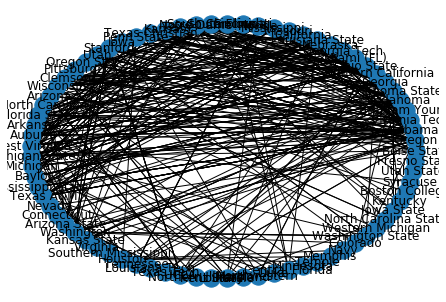

In [103]:
nx.draw_shell(MG_last_10, with_labels=True)

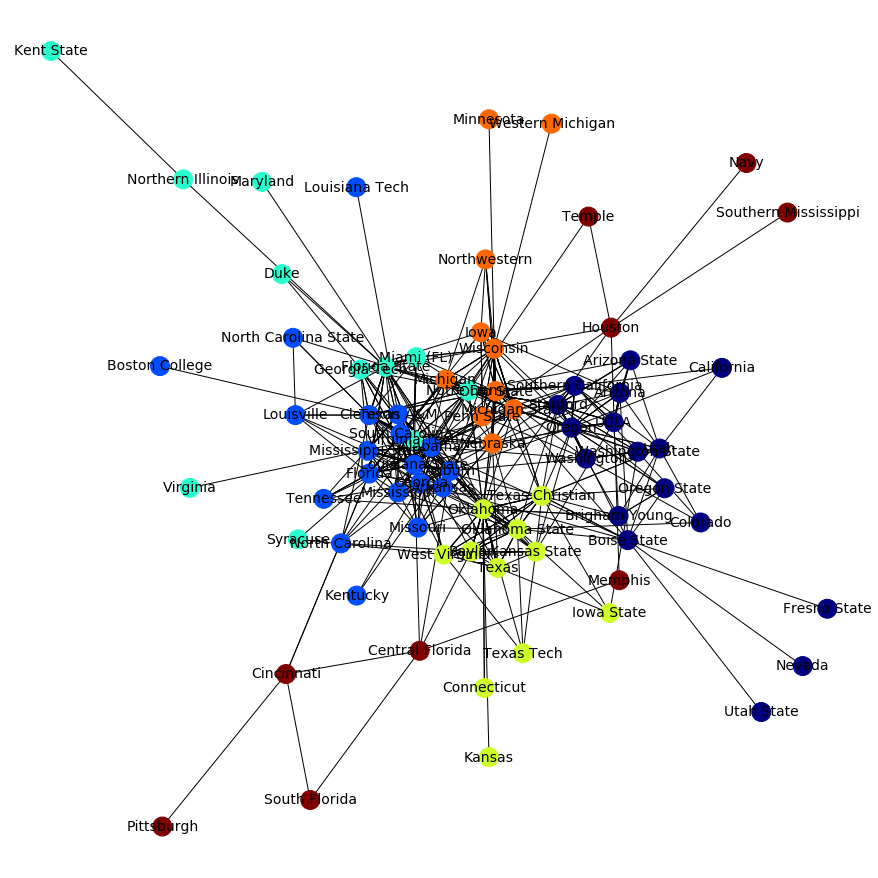

In [105]:
MG_last_10 = nx.from_pandas_edgelist(ranked_last_10, 'winner_name','loser_name', create_using=nx.MultiGraph)
g = MG_last_10
parts = community.best_partition(g)
values = [parts.get(node) for node in g.nodes()]

plt.figure(figsize=(12,12))
nx.draw(g, cmap = plt.get_cmap('jet'), node_color = values, node_size=360, font_size=14, with_labels=True)

plt.show()

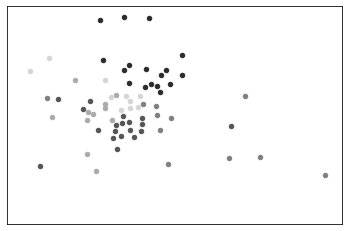

In [108]:
G = MG_last_10
#first compute the best partition
partition = community.best_partition(G)


size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

In [106]:
import operator

sorted_parts = sorted(parts.items(), key=operator.itemgetter(1))
sorted_parts

[('Boise State', 0),
 ('Oregon', 0),
 ('Brigham Young', 0),
 ('Southern California', 0),
 ('California', 0),
 ('Stanford', 0),
 ('Utah', 0),
 ('Oregon State', 0),
 ('Arizona', 0),
 ('Nevada', 0),
 ('Arizona State', 0),
 ('Washington', 0),
 ('UCLA', 0),
 ('Colorado', 0),
 ('Washington State', 0),
 ('Utah State', 0),
 ('Fresno State', 0),
 ('Alabama', 1),
 ('Georgia', 1),
 ('Louisiana State', 1),
 ('Missouri', 1),
 ('Mississippi', 1),
 ('Florida', 1),
 ('South Carolina', 1),
 ('Clemson', 1),
 ('North Carolina', 1),
 ('Arkansas', 1),
 ('Auburn', 1),
 ('Mississippi State', 1),
 ('Texas A&M', 1),
 ('Tennessee', 1),
 ('Louisiana Tech', 1),
 ('Louisville', 1),
 ('North Carolina State', 1),
 ('Kentucky', 1),
 ('Boston College', 1),
 ('Virginia Tech', 2),
 ('Miami (FL)', 2),
 ('Georgia Tech', 2),
 ('Notre Dame', 2),
 ('Florida State', 2),
 ('Virginia', 2),
 ('Northern Illinois', 2),
 ('Kent State', 2),
 ('Maryland', 2),
 ('Duke', 2),
 ('Syracuse', 2),
 ('Oklahoma', 3),
 ('Oklahoma State', 3),
 

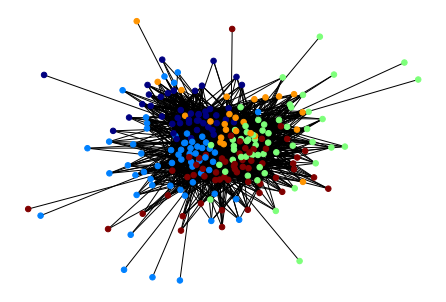

In [98]:
parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)

In [109]:
community.generate_dendrogram(G)

[{'Boise State': 0,
  'Oregon': 0,
  'Alabama': 1,
  'Virginia Tech': 2,
  'Brigham Young': 0,
  'Oklahoma': 3,
  'Oklahoma State': 4,
  'Georgia': 5,
  'Southern California': 0,
  'Ohio State': 6,
  'Miami (FL)': 2,
  'Georgia Tech': 2,
  'Nebraska': 6,
  'Louisiana State': 7,
  'California': 0,
  'Missouri': 8,
  'Mississippi': 8,
  'Florida': 5,
  'Cincinnati': 9,
  'South Florida': 9,
  'South Carolina': 8,
  'Notre Dame': 2,
  'Texas': 4,
  'Kansas': 3,
  'Texas Christian': 4,
  'Penn State': 6,
  'Iowa': 6,
  'Stanford': 10,
  'Utah': 0,
  'Oregon State': 0,
  'Pittsburgh': 9,
  'Clemson': 7,
  'Wisconsin': 6,
  'Arizona': 0,
  'North Carolina': 7,
  'Florida State': 2,
  'Arkansas': 8,
  'Auburn': 8,
  'West Virginia': 4,
  'Michigan State': 6,
  'Michigan': 6,
  'Baylor': 4,
  'Mississippi State': 8,
  'Texas A&M': 8,
  'Nevada': 0,
  'Connecticut': 3,
  'Arizona State': 0,
  'Washington': 10,
  'Kansas State': 4,
  'Virginia': 2,
  'Southern Mississippi': 11,
  'Houston': 11,


In [11]:
# should be number of teams
print(len(G.nodes))
# should be number of games
print(len(G.edges))

219
877


In [12]:
# should be number of teams
print(len(MG.nodes))
# should be number of games
print(len(MG.edges))

219
884


In [85]:
23.67 + 24.5 + 47.67 + 4.7

100.54

In [124]:
conf = pd.read_csv('conf_2018.csv', header=1)
conf['Div'] = conf['Conf'].str.extract('\((\w+)\)', expand=True)
conf['Conf'] = conf['Conf'].str.replace('\((\w+)\)','')

In [125]:
conf.head()

,Rk,School,Conf,W,L,Pct,W.1,L.1,Pct.1,Off,Def,SRS,SOS,AP Pre,AP High,AP Rank,Notes,Div
0,1,Clemson,ACC,15,0,1.000,8,0,1.000,44.3,13.1,26.45,5.19,2.0,1.0,1.0,NaN,Atlantic
1,2,Syracuse,ACC,10,3,0.769,6,2,0.750,40.2,27.0,12.14,1.30,NaN,12.0,15.0,NaN,Atlantic
2,3,North Carolina State,ACC,9,4,0.692,5,3,0.625,33.8,24.9,6.80,0.49,NaN,16.0,NaN,NaN,Atlantic
3,4,Boston College,ACC,7,5,0.583,4,4,0.500,32.0,25.7,4.61,1.78,NaN,17.0,NaN,NaN,Atlantic
4,5,Wake Forest,ACC,7,6,0.538,3,5,0.375,32.8,33.3,2.41,2.41,NaN,NaN,NaN,NaN,Atlantic


In [140]:
conf['Conf'].value_counts().index

Index(['Big Ten ', 'CUSA ', 'SEC ', 'ACC ', 'MAC ', 'American ', 'MWC ',
       'Pac-12 ', 'Big 12', 'Sun Belt ', 'Ind'],
      dtype='object')

In [136]:
power_5[2]

'ACC'

In [137]:
conf[conf['Conf'].isin([]

,Rk,School,Conf,W,L,Pct,W.1,L.1,Pct.1,Off,Def,SRS,SOS,AP Pre,AP High,AP Rank,Notes,Div


In [168]:
power_5 = ['Big Ten ', 'SEC ', 'ACC ', 'Pac-12 ', 'Big 12']
power_5_teams_df = conf[conf['Conf'].isin(power_5)]
power_5_teams = power_5_teams_df['School'].to_list()

In [146]:
power_5_recs = records[(records['winner_name'].isin(power_5_teams)) & (records['loser_name'].isin(power_5_teams))]

In [147]:
power_5_recs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16959 entries, (1950, 2, 19) to (2018, 21, 884)
Data columns (total 14 columns):
winner_pts     16959 non-null float64
loser_pts      16959 non-null float64
game_date      16959 non-null object
game_time      1702 non-null object
game_day       16959 non-null object
game_loc       6735 non-null object
notes          1606 non-null object
winner_home    16959 non-null bool
winner_rank    7312 non-null float64
winner_name    16959 non-null object
loser_rank     3363 non-null float64
loser_name     16959 non-null object
rank_diff      1966 non-null float64
pts_diff       16959 non-null float64
dtypes: bool(1), float64(6), object(7)
memory usage: 1.8+ MB


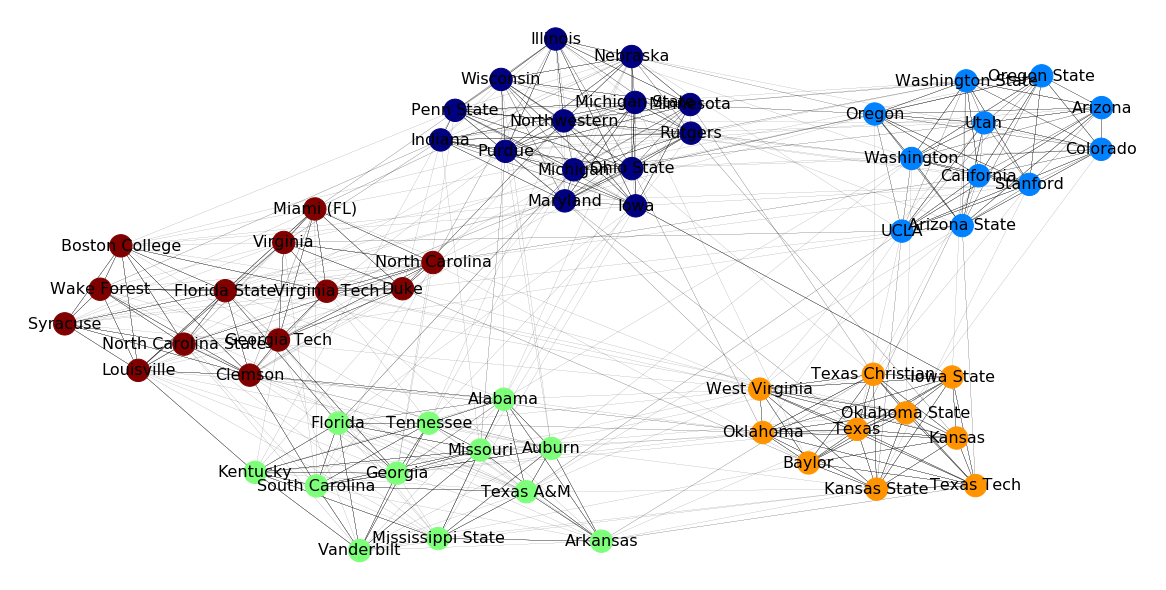

In [208]:
power_5_recs_last_5 = power_5_recs.loc[2014:2018]

MG_power_5_recs_last_5 = nx.from_pandas_edgelist(power_5_recs_last_5, 'winner_name','loser_name', create_using=nx.MultiGraph)
g = MG_power_5_recs_last_5
parts = community.best_partition(g)
values = [parts.get(node) for node in g.nodes()]

plt.figure(figsize=(16,8))
nx.draw(g, cmap = plt.get_cmap('jet'), node_color = values, node_size=500, font_size=16, with_labels=True, width=.1)

plt.show()

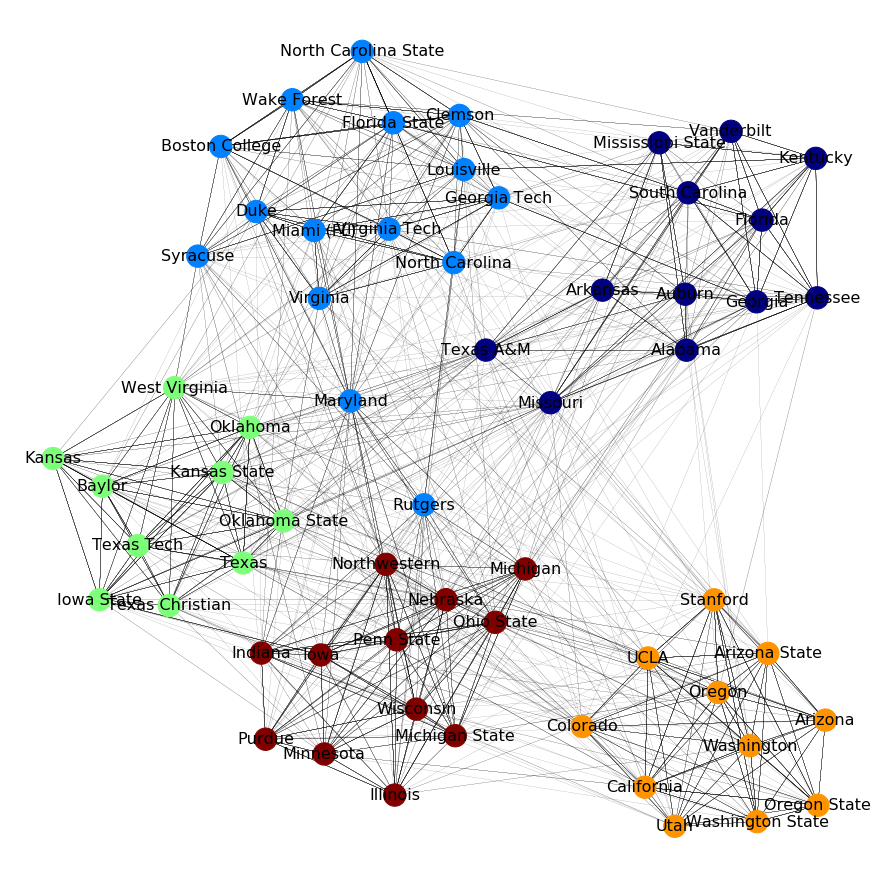

In [199]:
power_5_recs_last_5 = power_5_recs.loc[2009:2018]

MG_power_5_recs_last_5 = nx.from_pandas_edgelist(power_5_recs_last_5, 'winner_name','loser_name', create_using=nx.MultiGraph)
g = MG_power_5_recs_last_5
parts = community.best_partition(g)
values = [parts.get(node) for node in g.nodes()]

plt.figure(figsize=(12,12))
nx.draw(g, cmap = plt.get_cmap('jet'), node_color = values, node_size=500, font_size=16, with_labels=True, width=.1)

plt.show()

In [196]:
sorted_parts = sorted(parts.items(), key=operator.itemgetter(1))
sorted_parts

[('South Carolina', 0),
 ('Alabama', 0),
 ('Missouri', 0),
 ('Georgia', 0),
 ('Auburn', 0),
 ('Mississippi State', 0),
 ('Tennessee', 0),
 ('Florida', 0),
 ('Arkansas', 0),
 ('Kentucky', 0),
 ('Vanderbilt', 0),
 ('Texas A&M', 0),
 ('North Carolina State', 1),
 ('Virginia Tech', 1),
 ('Wake Forest', 1),
 ('Maryland', 1),
 ('Syracuse', 1),
 ('Miami (FL)', 1),
 ('Florida State', 1),
 ('Georgia Tech', 1),
 ('Clemson', 1),
 ('Virginia', 1),
 ('Boston College', 1),
 ('Duke', 1),
 ('Louisville', 1),
 ('North Carolina', 1),
 ('Rutgers', 1),
 ('Baylor', 2),
 ('Oklahoma State', 2),
 ('Iowa State', 2),
 ('Texas Christian', 2),
 ('West Virginia', 2),
 ('Kansas', 2),
 ('Texas', 2),
 ('Texas Tech', 2),
 ('Kansas State', 2),
 ('Oklahoma', 2),
 ('California', 3),
 ('Stanford', 3),
 ('Washington State', 3),
 ('Oregon', 3),
 ('UCLA', 3),
 ('Arizona', 3),
 ('Utah', 3),
 ('Oregon State', 3),
 ('Arizona State', 3),
 ('Washington', 3),
 ('Colorado', 3),
 ('Minnesota', 4),
 ('Illinois', 4),
 ('Iowa', 4),
 ('

In [169]:
parts_df = pd.DataFrame.from_dict(parts, orient='index', columns=['part_number'])
results = pd.merge(power_5_teams_df, parts_df, left_on='School', right_index=True, how='left')
results

,Rk,School,Conf,W,L,Pct,W.1,L.1,Pct.1,Off,Def,SRS,SOS,AP Pre,AP High,AP Rank,Notes,Div,part_number
0,1,Clemson,ACC,15,0,1.000,8,0,1.000,44.3,13.1,26.45,5.19,2.0,1.0,1.0,NaN,Atlantic,1.0
1,2,Syracuse,ACC,10,3,0.769,6,2,0.750,40.2,27.0,12.14,1.30,NaN,12.0,15.0,NaN,Atlantic,1.0
2,3,North Carolina State,ACC,9,4,0.692,5,3,0.625,33.8,24.9,6.80,0.49,NaN,16.0,NaN,NaN,Atlantic,1.0
3,4,Boston College,ACC,7,5,0.583,4,4,0.500,32.0,25.7,4.61,1.78,NaN,17.0,NaN,NaN,Atlantic,1.0
4,5,Wake Forest,ACC,7,6,0.538,3,5,0.375,32.8,33.3,2.41,2.41,NaN,NaN,NaN,NaN,Atlantic,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,116,Texas A&M,SEC,9,4,0.692,5,3,0.625,36.0,25.3,13.61,7.15,NaN,16.0,16.0,NaN,West,0.0
116,117,Mississippi State,SEC,8,5,0.615,4,4,0.500,28.5,13.2,13.24,5.93,18.0,14.0,NaN,NaN,West,0.0
117,118,Auburn,SEC,8,5,0.615,3,5,0.375,30.9,19.2,10.76,5.60,9.0,7.0,NaN,NaN,West,0.0
118,119,Ole Miss,SEC,5,7,0.417,1,7,0.125,33.9,36.2,2.81,4.39,NaN,NaN,NaN,NaN,West,NaN


In [172]:
results_clean = results[['School', 'Conf', 'part_number']]
results_clean.groupby('Conf').mean()

,part_number
Conf,
ACC,1.000000
Big 12,2.000000
Big Ten,3.571429
Pac-12,3.000000
SEC,0.000000


In [183]:
results_clean[results_clean['part_number'] == 1]

,School,Conf,part_number
0,Clemson,ACC,1.0
1,Syracuse,ACC,1.0
2,North Carolina State,ACC,1.0
3,Boston College,ACC,1.0
4,Wake Forest,ACC,1.0
5,Florida State,ACC,1.0
6,Louisville,ACC,1.0
8,Georgia Tech,ACC,1.0
9,Virginia,ACC,1.0
10,Miami (FL),ACC,1.0
